In [1]:
import time
import random
import signal
import math
import matplotlib.pyplot as plt
from graphviz import Digraph
from IPython.display import SVG

infty = float('inf')

## Utilities
### Decorators

In [2]:
def handler(sig, frame):
    raise Exception("Function takes too much time")

def timelimit(maxtime=100):
    def inner(func):
        def wrapper(*args, **kwargs):
            signal.signal(signal.SIGALRM, handler)
            signal.alarm(maxtime)
            try:
                res = func(*args, **kwargs)
            except Exception as exc:
                print(exc)
            else:
                signal.alarm(-1)
                return res
        return wrapper
    return inner

def timecounter(message=None):
    def inner(func):
        def wrapper(*args, **kwargs):
            start = time.time()
            res = func(*args, **kwargs)
            deltatime = (time.time() - start)*1000
            if message:
                try:
                    print(message.format(deltatime))
                except Exception:
                    print(f"Done in {deltatime}ms")
            elif message == False:
                return res, deltatime
            else:
                print(f"Done in {deltatime}ms")
            return res
        return wrapper
    return inner

def add_weights_svg(svg, weights):
    res_svg = svg.rsplit("\n", 3)[0]
    sep = 'pt" height="'
    a, b = res_svg.split(sep, 1)
    width = int(a[-3:])
    height = int(b[:3])
    h = height/len(weights)
    w_svg = "\n" + "\n".join([f"""<text text-anchor="middle" x="{width+20}" y="{-h*(i+.5)}" font-family="Times,serif" font-size="14.00">{x:.2f}</text>"""for i, x in enumerate(weights[::-1])])
    w_svg+="""\n</g>\n</svg>"""

    a = f"{a[:-3]}{width+100}"
    res_svg = a + sep + b + w_svg

    return res_svg

### Cache related functions

In [3]:
glob_cache = dict()

def reset_cache():
    glob_cache.clear()

def store_in_cache(k, node):
    if glob_cache.get(k):
        glob_cache[k].append(node)
    else:
        glob_cache.update({k: [node]})

def find_in_cache(k, value):
    cache_line = glob_cache.get(k)
    if cache_line:
        for node in cache_line:
            if value in node.interval:
                return node
    return None

def cache_total_node_count(cache):
    node_count = 0
    for x in cache.values():
        node_count+=x.__len__()
    return node_count

def odd_to_cache(odd):
    cache = {}
    cache[0] = [odd]
    has_child = odd.has_child()
    depth = 0
    next_layer = set()
    while has_child:
        layer = cache[depth]
        for node in layer:
            for child in node.child.values():
                next_layer.add(child)

        depth+=1
        cache[depth] = list(next_layer)
        next_layer.clear()
        has_child = cache[depth][0].has_child()
    
    return cache

### Draw graph

In [4]:
def make_graph_from_cache(cache, name=None):
    dot = Digraph()
    for cache_line in cache.values():
        for node in cache_line:
            dot.node(node.id, f"{node.interval:.2f}")
            for e, child in node.child.items():
                dot.edge(node.id, child.id, str(e))

    if name:
        dot.render(filename=f"odd/{name}")
    return dot._repr_image_svg_xml()

def make_graph_from_odd(odd, name=None):
    return make_graph_from_cache(odd_to_cache(odd),name)

## Class implementation

In [5]:
class Node:
    def __init__(self, interval=None, name=None):
        self.child = dict()
        self.parent = dict()
        self.interval = interval
        self.name = name
        self.id = f"n{id(self)}"

    def __str__(self):
        return f"{self.child.__len__()} children | {self.parent.__len__()} parents | {self.interval:.2f}"
    
    def add_child(self, other, label):
        self.child.update({label: other})
        other.parent.update({label: self})

    def pop_child(self, label):
        child = self.child.pop(label)
        child.parent.pop(label)
        return child

    def has_child(self):
        return len(self.child) > 0

class Interval:
    def __init__(self, low, high, closed_left=True, closed_right=True):
        self.low = low
        self.high = high
        self.left = closed_left
        self.right = closed_right
    
    def __str__(self):
        left = "[" if self.left else "("
        right = "]" if self.right else ")"
        return f"{left}{self.low}; {self.high}{right}"

    def __format__(self, __format_spec):
        left = "[" if self.left else "("
        right = "]" if self.right else ")"
        if __format_spec:
            return f"{left}{self.low:{__format_spec}}; {self.high:{__format_spec}}{right}"
        else:
            return f"{left}{self.low}; {self.high}{right}"

    def __add__(self, value):
        return Interval(self.low + value, self.high + value, self.left, self.right)

    def __sub__(self, value):
        return Interval(self.low - value, self.high - value, self.left, self.right)

    def __contains__(self, value):
        down = value >= self.low if self.left else value > self.low
        up = value <= self.high if self.right else value < self.high
        return down & up
    
    def intersect(self, other):
        if self.low < other.low:
            self.low = other.low
            self.left = other.left
        elif self.low == other.low:
            self.left &= other.left
        
        if self.high > other.high:
            self.high = other.high
            self.right = other.right
        elif self.high == other.high:
            self.right &= other.right

        return self

## Build ODD

In [6]:
@timecounter(message=False)
def timed_build_odd_rec(weights_list, threshold):
    return _build_odd_rec(weights_list, threshold)

def build_odd_rec(weights_list, threshold):
    return _build_odd_rec(weights_list, threshold)

@timelimit(600)
def _build_odd_rec(weights_list, threshold):
    n = len(weights_list)
    zero_sink = Node(Interval(-infty, threshold, closed_left=False, closed_right=False))
    store_in_cache(n, zero_sink)
    one_sink = Node(Interval(threshold, infty, closed_right=False))
    store_in_cache(n, one_sink)
    return build_sub_odd_rec(weights_list, 0, 0)

def build_sub_odd_rec(weights, k, v):
    node = Node(Interval(-infty, infty, closed_left=False, closed_right=False))
    weight = weights[k]
    for e in {0, 1}:
        w = e*weight
        v_child = v + w
        child = find_in_cache(k+1, v_child)
        if child is None:
            child = build_sub_odd_rec(weights, k+1, v_child)
        node.add_child(child, e)
        node.interval.intersect(child.interval-w)
    store_in_cache(k, node)
    return node

## Main

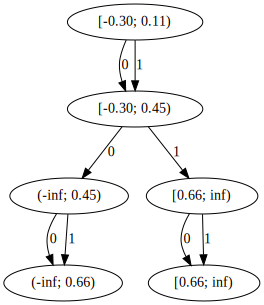

In [7]:
# input : list|orderedDict[tensor]
# output : connected odds

nn_repr = [([[random.random() for _ in range(2)] for _ in range(3)], [random.random() for _ in range(3)]), # Linear(2,3)
           ([[random.random() for _ in range(3)]], [random.random()])] # Linear(3,1)

odds_layers = []
for layer in nn_repr:
    odds = []
    for weights, threshold in zip(*layer):
        odds.append(build_odd_rec(weights, threshold))
        reset_cache()
    odds_layers.append(odds)
    
# print(odds_layers)
SVG(make_graph_from_odd(odds_layers[-1][0]))